In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("darkgrid")

In [158]:
# Get data file names
START_T_COUNT = 0
START_F_COUNT = 500
SPLIT_T_RATIO = 0.7

NUM_NO_FEAT_COLUMN = 3

## Static Funcs

In [159]:
def fe_basic_features(df):
    df_fe_1 = df.copy()
    df_fe_1.insert(0, 'accel_x', df_fe_1.acc_x + df_fe_1.grav_x)
    df_fe_1.insert(1, 'accel_y', df_fe_1.acc_y + df_fe_1.grav_y)
    df_fe_1.insert(2, 'accel_z', df_fe_1.acc_z + df_fe_1.grav_z)
    df_fe_1.insert(3, 'accel_norm', np.sqrt(df_fe_1.accel_x**2 + df_fe_1.accel_y**2 + df_fe_1.accel_z**2))
    df_fe_1 = df_fe_1.drop(['or_x', 'or_y', 'or_z', 'grav_x', 'grav_y', 'grav_z', 'acc_x', 'acc_y', 'acc_z'], axis=1)
    return df_fe_1

In [160]:
def fe_lag_features(df,n_lagwindow, cols):
    """
    Parameters
    ----------
    n : int       amount of lag features
    cols : list   list of columns to lag

    Returns
    -------
    pd.DataFrame    a dataframe with the list of columns lagged n times
    """
    lag_df = df.copy()
    NUM_FEAT_COLUMNS = len(df.columns)- NUM_NO_FEAT_COLUMN
    for j in cols:
        for i in range(n_lagwindow):
            lag_df.insert(NUM_FEAT_COLUMNS+i, j + '_lag' + str(i+1), lag_df[j].shift(i+1))
        
    # Dropping all rows where the lag overlapped two different subjects/trials (n timeframes at the beginning of every trial).
    for i in range(n_lagwindow):
        lag_df = lag_df.drop([i])
    
    return lag_df

In [161]:
def data_split_TrainTest(df):
    num_t_ds = len(df.query("action_num < @START_F_COUNT").action.unique())
    num_f_ds = len(df.query("action_num >= @START_F_COUNT").action.unique())

    num_train_t = round(num_t_ds * SPLIT_T_RATIO)
    num_train_f = round(num_f_ds * SPLIT_T_RATIO)

    train_df = df[(df.action_num.between(START_T_COUNT,START_T_COUNT+num_train_t,inclusive="both"))|
                    (df.action_num.between(START_F_COUNT,START_F_COUNT+num_train_f,inclusive="both"))]

    test_df = df[(df.action_num.between(START_T_COUNT+num_train_t,START_F_COUNT,inclusive="neither"))|
                    (df.action_num > START_F_COUNT+num_train_f)]
    

    return train_df,test_df

In [162]:
def data_split_FeatLabel(df):
    X = df.iloc[:,:(-1*NUM_NO_FEAT_COLUMN)]
    y = df.label
    return X,y

## Import Data

In [163]:
df_all = pd.read_pickle("merged_df.pkl")

## Feature engineering (basic)

In [164]:
df_fe = fe_basic_features(df_all)

## Data Splitting

In [165]:
train_df,test_df = data_split_TrainTest(df_fe)

In [166]:
len(train_df.action_num.unique()),len(test_df.action_num.unique())

(38, 15)

In [167]:
X_train,y_train = data_split_FeatLabel(train_df)
X_test,y_test = data_split_FeatLabel(test_df)

## Modeling

### DecisionTreeClassifier (baseline)

In [168]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtc = DecisionTreeClassifier(max_depth=4)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [207]:
print(f" Train data : {round(accuracy_score(y_train,dtc.predict(X_train))*100,3)} %")

 Train data : 80.546 %


In [208]:
print(f" Test data : {round(accuracy_score(y_test,dtc.predict(X_test))*100,3)} %")

 Test data : 76.058 %


#### Analyze results

In [170]:
len(train_df.action.unique())

38

In [171]:
train_df_res = train_df[["action","action_num","label"]]
train_df_res["predict"] = dtc.predict(X_train)

C:\Users\Jacqueline\AppData\Local\Temp\ipykernel_24956\2135228749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_res["predict"] = dtc.predict(X_train)


In [172]:
for num in train_df_res.action.unique():
    print(num,train_df_res.query("(action == @num)").predict.unique())

t_stand_front_drinksmallcup_10ml_1s_left [1 0]
f_sit_hold_EatFood_2sec_front [0 1]
t_sit_hold_DrinkCup_10ml_1s_hold [0 1]
t_sit_left_DrinkBottle_10ml_1s_hold [0 1]
t_stand_right_DrinkBottle_10ml_1s_hold [1 0]
f_sit_front_EatFood_2sec_front [0 1]
f_stand_front_LookMobile_2sec_front [1 0]
t_sit_left_DrinkBottle_10ml_1s_left [0 1]
f_stand_hold_EatFood_2sec_left [1 0]
t_stand_hold_DrinkBottle_10ml_1s_right [1 0]
f_stand_front_EatFood_2sec_hold [0 1]
t_stand_left_drinksmallcup_10ml_1s_hold [1 0]
t_stand_front_DrinkBottle_10ml_1s_hold [1 0]
t_stand_hold_DrinkCup_10ml_1s_right [1]
f_stand_hold_LookMobile_2sec_hold [0 1]
f_sit_hold_EatFood_2sec_left [0 1]
f_stand_hold_EatFood_2sec_front [1 0]
t_sit_front_DrinkBottle_10ml_1s_front [0 1]
t_stand_hold_DrinkCup_10ml_1s_hold [0 1]
t_sit_hold_DrinkCup_10ml_1s_front [1 0]
f_sit_right_EatFood_2sec_right [0 1]
f_stand_hold_LookMobile_2sec_right [0 1]
f_stand_front_EatFood_2sec_right [1 0]
t_stand_hold_DrinkCup_50ml_3s_hold [1]
f_stand_front_EatFood_2se

### Random ForestClassifier (baseline)

In [209]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100,max_depth=4)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4)

In [174]:
print(f" Train data : {round(accuracy_score(y_train,rfc.predict(X_train))*100,3)} %")

 Train data : 79.952 %


In [175]:
print(f" Test data : {round(accuracy_score(y_test,rfc.predict(X_test))*100,3)} %")

 Test data : 76.935 %


### Neurel Network

In [176]:
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model

from tensorflow.keras.layers import Dense
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [177]:
input_dim = X_train.shape[1]
cnn = Sequential()
cnn.add(Dense(80, input_dim=input_dim, activation='relu'))
cnn.add(Dense(40, activation='relu'))
cnn.add(Dense(20, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.01)
cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max'
                     , verbose=1, save_best_only=True)

In [178]:
#X_train, val_X, y_train, val_y = train_test_split(X_train, y_train, shuffle=True)

In [179]:
X_train_arr = np.asarray(X_train)
y_train_arr = np.asarray(y_train)
X_test_arr = np.asarray(X_test)
y_test_arr = np.asarray(y_test)
# val_X =  np.asarray(val_X)
# val_y =  np.asarray(val_y)

In [181]:
history = cnn.fit(X_train_arr, y_train_arr, epochs=100, batch_size=200
                  ,callbacks=[es,mc],validation_split=0.2)

Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 0.7315 - accuracy: 0.6568
Epoch 1: val_accuracy improved from -inf to 0.73216, saving model to best_model.h5
29/29 [==============================] - 4s 35ms/step - loss: 0.7315 - accuracy: 0.6568 - val_loss: 0.5832 - val_accuracy: 0.7322
Epoch 2/100
26/29 [=========================>....] - ETA: 0s - loss: 0.5722 - accuracy: 0.6990
Epoch 2: val_accuracy improved from 0.73216 to 0.77032, saving model to best_model.h5
29/29 [==============================] - 0s 13ms/step - loss: 0.5725 - accuracy: 0.6967 - val_loss: 0.5241 - val_accuracy: 0.7703
Epoch 3/100
25/29 [========================>.....] - ETA: 0s - loss: 0.5466 - accuracy: 0.7050
Epoch 3: val_accuracy did not improve from 0.77032
29/29 [==============================] - 0s 11ms/step - loss: 0.5508 - accuracy: 0.7002 - val_loss: 0.5313 - val_accuracy: 0.7675
Epoch 4/100
24/29 [=======================>......] - ETA: 0s - loss: 0.5381 - accuracy: 0.7000
Epoch 4: v

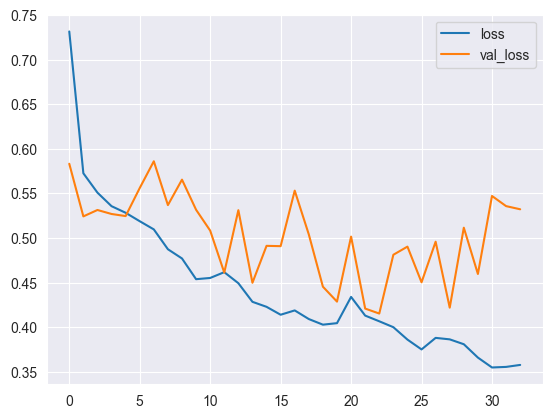

In [182]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss',"val_loss"]].plot()
plt.show()

#### Evaluation

- Evaluate last saved model (which is not the best option)

In [183]:
from sklearn.metrics import mean_absolute_error
 
predictions = cnn.predict(X_test_arr)
mean_absolute_error(y_test, predictions)

82/82 [==============================] - 0s 3ms/step


0.29296919509671404

- Evaluate best model which was monitored and saved

In [184]:
best_saved_model = load_model('best_model.h5')
_, train_acc = best_saved_model.evaluate(X_train_arr, y_train_arr, verbose=0)
_, test_acc = best_saved_model.evaluate(X_test_arr, y_test_arr, verbose=0)
print('Train Data: %.3f, Test data: %.3f' % (train_acc, test_acc))

Train Data: 0.776, Test data: 0.753


In [185]:
best_model_predictions = best_saved_model.predict(X_train_arr)
print(f" Train data : {round(mean_absolute_error(y_train, best_model_predictions)*100,3)} %")

222/222 [==============================] - 1s 3ms/step
 Train data : 29.578 %


In [186]:
best_model_predictions = best_saved_model.predict(X_test_arr)
print(f" Test data : {round(mean_absolute_error(y_test, best_model_predictions)*100,3)} %")

82/82 [==============================] - 0s 4ms/step
 Test data : 31.822 %


In [187]:
best_model_predictions

array([[0.7117072 ],
       [0.7054252 ],
       [0.83823717],
       ...,
       [0.9940027 ],
       [0.9958638 ],
       [0.9967898 ]], dtype=float32)

## Feature engineering (Lagging)
create info from consecutive points in time in one row.
How to create :  copy one feature into a new column and shift it one or more rows down. Depending on the amount n of lag features, the dataframe gets n additional columns with n shifts in time.

In [188]:
lag_df = fe_lag_features(df_fe,15, ['accel_norm',"rotR_x","rotR_y","rotR_z"])

In [210]:
len(lag_df.columns)

70

## Data Splitting

In [190]:
train_df_lag,test_df_lag = data_split_TrainTest(lag_df)

In [191]:
len(train_df_lag.action_num.unique()),len(test_df_lag.action_num.unique())

(38, 15)

In [192]:
X_train_lag,y_train_lag = data_split_FeatLabel(train_df)
X_test_lag,y_test_lag = data_split_FeatLabel(test_df)

## Modeling

### Random ForestClassifier (baseline)

In [214]:
from sklearn.ensemble import RandomForestClassifier

lag_rfc = RandomForestClassifier(n_estimators=100,max_depth=4)
lag_rfc.fit(X_train_lag, y_train_lag)

RandomForestClassifier(max_depth=4)

In [215]:
print(f" The acurracy for Train data is: {round(accuracy_score(y_train_lag,lag_rfc.predict(X_train_lag))*100,3)} %")

 The acurracy for Train data is: 80.023 %


In [216]:
print(f" The acurracy for Train data is: {round(accuracy_score(y_test_lag,lag_rfc.predict(X_test_lag))*100,3)} %")


 The acurracy for Train data is: 78.04 %


### Neurel Network

In [196]:
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model

from tensorflow.keras.layers import Dense
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [197]:
input_dim = X_train_lag.shape[1]
cnn = Sequential()
cnn.add(Dense(80, input_dim=input_dim, activation='relu'))
cnn.add(Dense(40, activation='relu'))
cnn.add(Dense(20, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

In [198]:
opt = keras.optimizers.Adam(learning_rate=0.01)

cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#X_train, val_X, y_train, val_y = train_test_split(X_train, y_train, shuffle=True)

In [199]:
X_train_arr = np.asarray(X_train_lag)
y_train_arr = np.asarray(y_train_lag)
X_test_arr = np.asarray(X_test_lag)
y_test_arr = np.asarray(y_test_lag)
# val_X =  np.asarray(val_X)
# val_y =  np.asarray(val_y)

In [200]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


In [201]:
history = cnn.fit(X_train_arr, y_train_arr, epochs=100, batch_size=200,callbacks=[es,mc]
                  #, validation_data=(test_X,test_y)
                  ,validation_split=0.2
                  )


Epoch 1/100
24/29 [=======================>......] - ETA: 0s - loss: 0.6753 - accuracy: 0.6698
Epoch 1: val_accuracy improved from -inf to 0.71661, saving model to best_model.h5
29/29 [==============================] - 2s 26ms/step - loss: 0.6570 - accuracy: 0.6767 - val_loss: 0.5906 - val_accuracy: 0.7166
Epoch 2/100
25/29 [========================>.....] - ETA: 0s - loss: 0.5578 - accuracy: 0.7006
Epoch 2: val_accuracy improved from 0.71661 to 0.72933, saving model to best_model.h5
29/29 [==============================] - 0s 10ms/step - loss: 0.5574 - accuracy: 0.7001 - val_loss: 0.5410 - val_accuracy: 0.7293
Epoch 3/100
26/29 [=========================>....] - ETA: 0s - loss: 0.5420 - accuracy: 0.7002
Epoch 3: val_accuracy did not improve from 0.72933
29/29 [==============================] - 0s 8ms/step - loss: 0.5426 - accuracy: 0.7013 - val_loss: 0.5506 - val_accuracy: 0.7293
Epoch 4/100
26/29 [=========================>....] - ETA: 0s - loss: 0.5359 - accuracy: 0.7002
Epoch 4: va

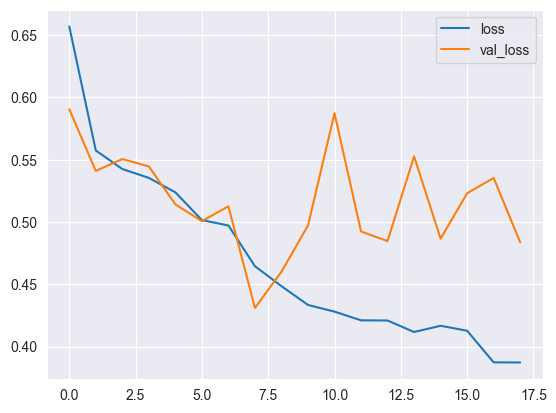

In [202]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss',"val_loss"]].plot()
plt.show()

#### Evaluation

- Evaluate last saved model (which is not the best option)

In [203]:
from sklearn.metrics import mean_absolute_error
 
predictions = cnn.predict(X_test_arr)
mean_absolute_error(y_test_lag, predictions)

82/82 [==============================] - 1s 5ms/step


0.28199970984906014

- Evaluate best model which was monitored and saved

In [204]:
best_saved_model = load_model('best_model.h5')
_, train_acc = best_saved_model.evaluate(X_train_arr, y_train_arr, verbose=0)
_, test_acc = best_saved_model.evaluate(X_test_arr, y_test_arr, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.761, Test: 0.750


In [205]:
#TODO use saved_model to predict data
best_model_predictions = best_saved_model.predict(X_test_arr)
mean_absolute_error(y_test_lag, best_model_predictions)

82/82 [==============================] - 0s 3ms/step


0.3153974213771003

In [206]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(best_model_predictions, y_test_lag)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
conf_mat_disp.plot(cmap='Greens')
plt.show()

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [ ]:
np.argmax(100)

0